In [67]:
!pip install -q kaggle
import time
import zipfile
import os
import json
import cv2
import keras

Using TensorFlow backend.


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pernelkanic","key":"036cfdc2baea2fa58f51243e4b73b9af"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
start = time.time()
!kaggle competitions download airbus-ship-detection
print("downloading dataset took {} seconds".format(time.time()-start))

  0% 0.00/274k [00:00<?, ?B/s]
100% 274k/274k [00:00<00:00, 61.4MB/s]
 50% 9.00M/18.0M [00:00<00:00, 24.0MB/s]
100% 18.0M/18.0M [00:00<00:00, 40.9MB/s]
 99% 2.11G/2.12G [00:27<00:00, 121MB/s] 
100% 2.12G/2.12G [00:27<00:00, 82.1MB/s]
100% 26.4G/26.4G [04:36<00:00, 124MB/s]
100% 26.4G/26.4G [04:36<00:00, 102MB/s]


In [0]:
download_sample_submissions = "0" #@param ["0","1"]
if download_sample_submissions == "1":
  from google.colab import files
  files.download("/content/sample_submission_v2.csv")

In [0]:
import zipfile
!mkdir -p /contents/test_v2
zip_ref = zipfile.ZipFile("/content/test_v2.zip", 'r')
zip_ref.extractall("/contents/test_v2")
zip_ref.close()
!mkdir -p /contents/train_v2
zip_ref = zipfile.ZipFile("/content/test_v2.zip",, 'r')
zip_ref.extractall("/contents/train_v2")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/train_ship_segmentations_v2.csv.zip", 'r')
zip_ref.extractall("/contents/")
zip_ref.close()

In [0]:
for file in ["/content/test_v2.zip","/content/train_v2.zip","/content/train_ship_segmentations_v2.csv.zip"]:
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

In [0]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv("/content/train_ship_segmentations_v2.csv", index_col=0).dropna()
display(df.head())
df['EncodedPixels']['000155de5.jpg']


,EncodedPixels
ImageId,
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...


'264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 339922 33 340690 33

In [24]:
rle = [int(i) for i in df['EncodedPixels']['000155de5.jpg'].split()]
# turn list of ints into a list of (`start`, `length`) `pairs`
pairs = list(zip(rle[0:-1:2], rle[1:-2:2])) 
pairs[:3]

[(264661, 17), (265429, 33), (266197, 33)]

In [25]:
start = pairs[0][0]
print(f"Original start position: {start}")

coordinate = (start % 768, start // 768)
print(f"Maps to this coordinate: {coordinate}")

back = 768 * coordinate[1] + coordinate[0]
print(f"And back: {back}")

Original start position: 264661
Maps to this coordinate: (469, 344)
And back: 264661


In [0]:
def rle_to_pixels(rle_code):
    '''
    Transforms a RLE code string into a list of pixels of a (768, 768) canvas
    '''
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1:-2:2])) 
                 for pixel_position in range(start, start + length)]
    return pixels


In [0]:
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util.montage import montage2d as montage

def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)
  
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

Image 000155de5.jpg
Found bbox (465, 344, 501, 448)


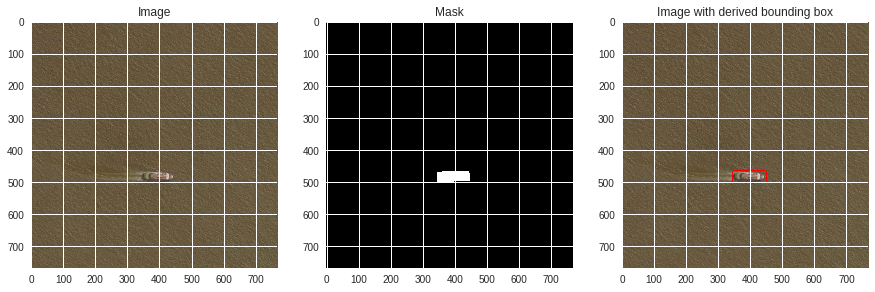

In [66]:
for i in range(1):
    image = df.iloc[i].ImageId
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
    img_0 = cv2.imread(image)
    rle_0 = df.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    #
    # 
    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    img_1 = img_0.copy()
    print ('Image', image)
    for prop in props:
        print('Found bbox', prop.bbox)
        cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)


    ax1.imshow(img_0)
    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax3.set_title('Image with derived bounding box')
    ax2.imshow(mask_0[...,0], cmap='gray')
    ax3.imshow(img_1)
    plt.show()

In [2]:
!ls sample_data


anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md
